# Load Package & Config ini

In [12]:
#configparser
import configparser
global HOST,PORT,DB_ID,DB_PW,MODEL_DIR,MODEL_NAME
conf_dir = '/home/cdsadmin/python_src/EY/Emart/conf/config.ini'
cfg = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
cfg.read(conf_dir)
# default package 
import numpy as np
import pandas as pd 
import time,os,psutil
import IPython
from datetime import datetime
from IPython.lib import kernel
import collections
import itertools
import pickle,ast,joblib
## hana DB client 
from hdbcli import dbapi 
from IPython.core.display import display, Image
import multiprocessing
import sqlite3

#visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import plot_confusion_matrix

from collections import Counter

# feature selection 
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# split data & sampling for imbalanced set
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from multi_imbalance.utils.min_int_maj import maj_int_min

# predict model
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from vecstack import stacking
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier,XGBRFClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso

#confusion matrix (measure)
from sklearn.metrics import confusion_matrix,precision_score,recall_score,\
                              f1_score,accuracy_score,roc_auc_score,roc_curve,auc,\
                              classification_report,precision_recall_curve
from sklearn.model_selection import cross_val_score,KFold
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

#--------------------------------------------------------
# ■ setting configuration (db_connectionm, load_model)
#--------------------------------------------------------
HOST  = cfg['dbconnect']['host']
PORT  = int(cfg['dbconnect']['port'])
DB_ID = cfg['dbconnect']['ID']
DB_PW = cfg['dbconnect']['PW']
MODEL_DIR  = cfg['Mollys']['MODEL_DIR']
# MODEL_NAME = cfg['Mollys']['MODEL_NAME']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 90)
pd.set_option('display.width', 1000)
pd.set_option('mode.chained_assignment',  None) # <==== turn off warining message 

['/home/cdsadmin/python_src/EY/Emart/conf/config.ini']

# MultiProcessing

In [13]:
# %load ./multiprocessing_sequence.py
## --------------------------------------------------
## load_data
## --------------------------------------------------
## multiprocessing 준비
def check_pid():
    connection_file_path = kernel.get_connection_file()
    connection_file      = os.path.basename(connection_file_path)
    kernel_id            = connection_file.split('-', 1)[1].split('.')[0]
    print('■ [PID]          : %s '%os.getpid())
    print('■ [Jupyter path] : %s' %os.getcwd())
    print('■ [Kernel ID]    : %s' %kernel_id)

def timecheck(start):
    learn_time = time.time() - start
    train_time = round(learn_time/60)  
    print("소요시간 :",  round(learn_time,-1), "초", "  (",train_time, "분 )\n")
    return learn_time,train_time
    
def DB_Connection() :
    conn=dbapi.connect(HOST,PORT,DB_ID,DB_PW)
    return conn

def Datachunk_range(rownum_sql) :
    conn = DB_Connection()
    cnt  = pd.read_sql(rownum_sql, conn)
    key  = int(cnt.values)
    print('Data  count : %s'%key)
    rm   = key % n_core
    ## Split row_num / n_core 
    arg_list_flt =[i for i in range(0,key,int(key/n_core))]
    ## last sequence add remainder 
    if rm > 0:
        arg_list_flt[len(arg_list_flt)-1] = arg_list_flt[len(arg_list_flt)-1]+rm
    else:
        arg_list_flt.append(arg_list_flt[-1]+arg_list_flt[1])
    conn.close()        
    return arg_list_flt,rm

def SQL_worker(num):    
    b = int(arg_list.index(num))-1
    if (int(arg_list.index(num)) == 0) :
        result = None
    else :
        start_num = int(arg_list[b])+1
        end_num   = int(num)
        print('start_num : %s | end_num : %s'%(start_num,end_num))
        sql =f'''
                SELECT *
                FROM (SELECT   ROW_NUMBER() OVER (ORDER BY CUST_ID ASC) AS ROW_NUM
                             , *
                      FROM  {db_name}) T1
                WHERE T1.ROW_NUM between {start_num} and {end_num}
              '''
        conn = DB_Connection()
        result = pd.read_sql(sql, conn)
        conn.close()
    return result

def multiprocesser(arg_list) : 
    check_pid()
    print('\nstart_arg_list : %s \n'%arg_list)
    p = multiprocessing.Pool(processes = n_core)
    data = p.map(SQL_worker, arg_list) 
    p.close()
    p.join()
    result = pd.concat(data)
    return result   

def check_cpu_percent(num):
    cpu_cnt = len(psutil.Process().cpu_affinity())
    c_list = psutil.cpu_percent(percpu=True)
    available_cpu_cnt = len([i for i in c_list if i < 1])
    n_core = np.trunc(available_cpu_cnt/num)
    print('[ total_cpu_cnt ] : ',cpu_cnt)
    print('[ available_cpu_cnt ] : ',available_cpu_cnt)
    return int(n_core)


# Feature Scling (Part1)

In [14]:
def part1_feature_select():
    DOG_Y_label = 'DOG_FOOD_BUY_YN'
    CAT_Y_label = 'CAT_FOOD_BUY_YN'
    all_feature = [ 'LAST_VISIT_DATE_DIFF'
                    ,'TOT_FREQUENCY_CNT'
                    ,'TOT_RCIP_PRDT_CNT'
                    ,'TOT_PREMIUM_PRDT_CNT'
                    ,'PREMIUM_PRDT_CNT_RT'
                    ,'TOT_SALE_AMT'
                    ,'TOT_SALE_QTY'
                    ,'TOT_MCODE_CNT'
                    ,'BUY_PRDT_CD_CNT'
                    ,'RFM_LV_DI_MOLLYS'
                    ,'TOP1_STR_CD'
                    ,'TOP2_STR_CD'
                    ,'TOT_MCODE_126_FREQ_CNT'
                    ,'TOT_MCODE_126_SALE_AMT'
                    ,'TOT_MCODE_123_FREQ_CNT'
                    ,'TOT_MCODE_123_SALE_AMT'
                    ,'TOT_MCODE_124_FREQ_CNT'
                    ,'TOT_MCODE_124_SALE_AMT'
                    ,'TOT_MCODE_125_FREQ_CNT'
                    ,'TOT_MCODE_125_SALE_AMT'
                    ,'TOT_MCODE_76_FREQ_CNT'
                    ,'TOT_MCODE_76_SALE_AMT'
                    ,'TOT_MCODE_79_FREQ_CNT'
                    ,'TOT_MCODE_79_SALE_AMT']
    DOG_X_feature = ['TOT_DCODE_2716_FREQ_CNT'
                    ,'TOT_DCODE_2716_SALE_AMT'
                    ,'TOT_MCODE_74_FREQ_CNT'
                    ,'TOT_MCODE_74_SALE_AMT'
                    ,'TOT_MCODE_77_FREQ_CNT'
                    ,'TOT_MCODE_77_SALE_AMT'
                    ,'TOT_MCODE_318_FREQ_CNT'
                    ,'TOT_MCODE_318_SALE_AMT'
                    ,'TOT_MCODE_477_FREQ_CNT'
                    ,'TOT_MCODE_477_SALE_AMT'
                    ,'TOT_MCODE_478_FREQ_CNT'
                    ,'TOT_MCODE_478_SALE_AMT']
    CAT_X_feature = ['TOT_MCODE_277_FREQ_CNT'
                    ,'TOT_MCODE_277_SALE_AMT'
                    ,'TOT_MCODE_279_FREQ_CNT'
                    ,'TOT_MCODE_279_SALE_AMT'
                    ,'TOT_MCODE_281_FREQ_CNT'
                    ,'TOT_MCODE_281_SALE_AMT'
                    ,'TOT_MCODE_280_SALE_AMT'
                    ,'TOT_MCODE_280_FREQ_CNT']
    return all_feature,DOG_Y_label,CAT_Y_label,DOG_X_feature,CAT_X_feature


# Confusion_Matrix & Model_score

In [15]:
def model_score(**args):
    global TN,TP,FN,FP
    global acc_s,f1_s,recall_s,precision_s,auc_score    
    global class_cat,model_key
    test_y = args['y_test']
    pred_y = args['y_pred']
    pred_y_prob = args['y_pred_prob']
    cm_matrix                = confusion_matrix(test_y,pred_y)
    TN                       = int(cm_matrix[0][0])
    FP                       = int(cm_matrix[0][1])
    FN                       = int(cm_matrix[1][0])
    TP                       = int(cm_matrix[1][1])
    FPR                      = float(1-(TN / (FP+TN)))
    acc_s                    = float(accuracy_score(test_y, pred_y))
    precision_s              = float(precision_score(test_y, pred_y))
    recall_s                 = float(recall_score(test_y, pred_y))
    f1_s                     = float(f1_score(test_y, pred_y))
    pred_target_cnt          = len(pred_y[pred_y == 1])
    pred_non_target_cnt      = len(pred_y[pred_y == 0])
    print("==============================   ACCURACY  =================================")
    print("ACCURACY : {0:.2F}%".format(acc_s))
    print("============================================================================")
    print("==============================   COUNT DATA   ==============================")
    print("test_Target_Count : %s"%(len(test_y[test_y == 1])))
    print("pred_Target_Count : %s"%(len(pred_y[pred_y == 1])))
    print("===========================   Confusion Matrix   ===========================")
    print(cm_matrix)
    print("TN : %s"% TN)
    print("TP : %s"% TP)
    print("FN : %s"% FN)
    print("FP : %s"% FP)
    print("============================================================================")
    print("=========================   Precision / Recall   ===========================")
    print("precision_rate : %.2f (TP+/TP+FP)" % precision_s)
    print("recall_rate : %.2f (TP+/TP+FN)" % recall_s)
    print("=============================   F1 SCORE   =================================")
    print("f1_score :  %.2f (2*((precision * recall)/(precision+recall)))"%f1_s)
    print("============================================================================\n\n")      
    print(classification_report(test_y, pred_y, digits=3))

# Split Train / Test

In [16]:
#Split dataset (default = train(80%),test(20%))
def split_train_test(df,size,x_feature,cat,Y_label):
    global model_input_x
    model_input_x  = x_feature
    X              = df[['ROW_NUM']+x_feature]
    X              = X.set_index(X['ROW_NUM'],inplace = False)
    X              = X[x_feature]
    Y              = df[['ROW_NUM',Y_label]]
    Y              = Y.set_index(Y['ROW_NUM'],inplace = False)
    Y              = Y[[Y_label]]
    # ■ random state = seed for shuffle
    if cat == 'random':
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[Y_label], test_size=size, random_state=123)
    else :
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[Y_label], test_size=size, random_state=123,stratify=Y[Y_label])        
    return X_train, X_test, Y_train, Y_test

def save_model(clf,mdl_file_nm):
    model = joblib.dump(clf,open(MODEL_DIR+mdl_file_nm+".pkl",'wb'))
    print('%s 경로에 %s 모델 저장완료 '%(MODEL_DIR,mdl_file_nm+".pkl"))
    
def load_model(filename):
    model_dir  = MODEL_DIR+filename
    load_model = joblib.load(model_dir)
    return load_model

def dict_product(param):
    return (dict(zip(param,x)) for x in itertools.product(*param.values())) 

# Hyper Parameter Estimator

In [ ]:
def HyperPram_RandseachCV(X_train, Y_train,ml_cat):
    print('HyperPrameter (RandomizedSearchCV)')
    check_pid()
    start = time.time()
    if ml_cat =='xgb':
        clf = XGBClassifier()
        gridParams = {'n_estimators': [5,400],
                     'learning_rate': [0.01,0.05],
                     'subsample': [0.5,0.8],
                     'objective' : ['multi:softmax'],
                     'max_depth' : [5,20],
                     'colsample_bytree': [0.5, 0.9],
                     'min_child_weight': [1, 4]
                    }
    elif ml_cat =='lgbm':
        clf = LGBMClassifier()
        gridParams = {
                        'n_estimators': [5,400],
                        'learning_rate': [0.01,0.09],
                        'num_leaves': [50,200],
                        'boosting_type' : ['gbdt'],
                        'max_depth' : [5,40],
                        'random_state' : [123], 
                        'subsample' : [0.5,0.8],
                        'min_split_gain' : [0.01],
                        'min_data_in_leaf':[10],
                    }
    grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=5)
    grid.fit(X_train,Y_train)
    best_params = grid.best_params_
    timecheck(start)
    return best_params

# Classifier (LGBM)

In [ ]:
def clf_predict(cat,X_train,X_test,Y_train,Y_test):
    print('MODEL : %s'%cat )
    print(f'Train shape  : {X_train.shape}')
    print(f'Test shape   : {X_test.shape}')
    print(f'Train Target : {len(Y_train[Y_train == 1])}  | Non_Target : {len(Y_train[Y_train == 0])}')
    print(f'Test Target  : {len(Y_test[Y_test == 1])}    | Non_Target : {len(Y_test[Y_test == 0])}')

    X  = X_train
    y  = Y_train

    clf = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                       importance_type='split', learning_rate=0.05, max_depth=50,
                                       min_child_samples=20, min_child_weight=0.001,
                                       min_split_gain=0.05, n_estimators=500, n_jobs=10,
                                       num_leaves=400, objective=None, random_state=123, reg_alpha=0.0,
                                       reg_lambda=0.0, silent=True, subsample=0.7,
                                       subsample_for_bin=200000, subsample_freq=0)

    evals = [(X_test,Y_test)]
    clf.fit(X,y,early_stopping_rounds=200,eval_metric='error',eval_set=evals)
    y_pred      = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)

    model_score(y_test = Y_test,y_pred = y_pred ,y_pred_prob = y_pred_prob)
    return clf

# Permutation Importance

In [29]:
def PermutaionImportance(clf,X_train,y_train):
    count_class = str(Counter(y_train))
    X = X_train
    y = y_train
    start = time.time()
    print('PI')
    print(count_class)
    check_pid()
    
    clf.fit(X,y)
    result     = permutation_importance(clf, X, y, n_repeats=5, random_state=42, n_jobs=10)
    sorted_idx = result.importances_mean.argsort()
    
    # visualiazation Permutation Importance
    fig, ax = plt.subplots(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = X.columns[sorted_idx] )
    ax.set_title("Permutation_impotances_Test",fontsize=24)
    plt.yticks(fontsize=16)
    fig.tight_layout()
    plt.show()
    importance_t = result.importances_mean[sorted_idx]
    PI_feature = X.columns[sorted_idx]
    
    df_1 = pd.DataFrame(importance_t,PI_feature).reset_index()
    df_1.columns =  ['FEATURE_NAME','IMPORTANCE_PI']
    last_pi = df_1.sort_values('IMPORTANCE_PI',ascending=False)    

    timecheck(start)
    return last_pi


# Feature Importance(GAIN)

In [33]:
def clf_feature_importance(mdl_nm):
    p_model_clf = load_model(mdl_nm)
    print(p_model_clf.feature_name_)
    
    mdl_fi = pd.DataFrame({'FEATURE_NAME' : p_model_clf.feature_name_,
                           'IMPORTANCE_SPLIT' : list(p_model_clf.feature_importances_),
                           'IMPORTANCE_GAIN':list(p_model_clf.booster_.feature_importance(importance_type='gain'))})
    mdl_fi['SPLIT_RANK'] = mdl_fi['IMPORTANCE_SPLIT'].rank(ascending=False)
    mdl_fi['GAIN_RANK'] = mdl_fi['IMPORTANCE_GAIN'].rank(ascending=False)
    mdl_fi.sort_values(by=['GAIN_RANK'],ascending = True) 
    plt.figure(figsize=(20, 20))
    
    sns.barplot(x="IMPORTANCE_GAIN", y="FEATURE_NAME", data=mdl_fi.sort_values(by="IMPORTANCE_GAIN", ascending=False))
    return mdl_fi

# DATA LOAD

In [9]:
db_name  = 'EY_YSR_MOLLYS_FOOD_TRAIN_BAIN_202008'

n_core  = 5
print('[n_core] : ',n_core)
cnt_sql  = f''' SELECT COUNT(1)
                FROM {db_name}'''
arg_list,rm = Datachunk_range(rownum_sql = cnt_sql)
df = multiprocesser(arg_list)
# ===============================================================
print('all_df count : %s '% len(df))
print(df.shape)
df = df.fillna(0)

[n_core] :  5
Data  count : 855732
■ [PID]          : 199659 
■ [Jupyter path] : /home/cdsadmin/python_src/EY/YSR
■ [Kernel ID]    : a76ea463-4c65-4659-8a9b-68022eae5998

start_arg_list : [0, 171146, 342292, 513438, 684584, 855732] 

start_num : 171147 | end_num : 342292
start_num : 1 | end_num : 171146
start_num : 684585 | end_num : 855732
start_num : 342293 | end_num : 513438
start_num : 513439 | end_num : 684584
all_df count : 855732 
(855732, 48)


# Feature sclicing (PART1)

In [18]:
all_feature,DOG_Y_label,CAT_Y_label,DOG_X_feature,CAT_X_feature = part1_feature_select()

# Splig Train / Test

In [ ]:
#dog DataSet split
D_X_train, D_X_test, D_Y_train, D_Y_test = split_train_test(df,0.2,all_feature+DOG_X_feature,'stratify',DOG_Y_label)
#Cat DataSet split
C_X_train, C_X_test, C_Y_train, C_Y_test = split_train_test(df,0.2,all_feature+CAT_X_feature,'stratify',CAT_Y_label)

# Hyper Parameter Estimator 

In [ ]:
cat_randomcv_hyperparam = HyperPram_RandseachCV(C_X_train, C_Y_train,'lgbm')
dog_randomcv_hyperparam = HyperPram_RandseachCV(D_X_train, D_Y_train,'lgbm')

# Classifier (LGBM)

In [19]:
dog_model =  clf_predict('DOG_POTENTIAL_FOOD_MODEL',D_X_train, D_X_test, D_Y_train, D_Y_test)
cat_model =  clf_predict('CAT_POTENTIAL_FOOD_MODEL',C_X_train, C_X_test, C_Y_train, C_Y_test)

MODEL : DOG_POTENTIAL_FOOD_MODEL
Train shape  : (684585, 36)
Test shape   : (171147, 36)
Train Target : 104725  | Non_Target : 579860
Test Target  : 26181    | Non_Target : 144966
[1]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.393317
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.36645
[3]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.344452
[4]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.325788
[5]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.309591
[6]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.295309
[7]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.282473
[8]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.270962
[9]	valid_0's binary_error: 0.152974	valid_0's binary_logloss: 0.260559
[10]	valid_0's binary_error: 0.152793	valid_0's binary_logloss: 0.251043
[11]	valid_0's binary_error: 0.110396	

[113]	valid_0's binary_error: 0.0399598	valid_0's binary_logloss: 0.106016
[114]	valid_0's binary_error: 0.0399364	valid_0's binary_logloss: 0.105918
[115]	valid_0's binary_error: 0.0398429	valid_0's binary_logloss: 0.105801
[116]	valid_0's binary_error: 0.0397904	valid_0's binary_logloss: 0.105719
[117]	valid_0's binary_error: 0.0397845	valid_0's binary_logloss: 0.105613
[118]	valid_0's binary_error: 0.0397378	valid_0's binary_logloss: 0.105463
[119]	valid_0's binary_error: 0.039691	valid_0's binary_logloss: 0.105406
[120]	valid_0's binary_error: 0.0396501	valid_0's binary_logloss: 0.105313
[121]	valid_0's binary_error: 0.0396443	valid_0's binary_logloss: 0.105211
[122]	valid_0's binary_error: 0.0396034	valid_0's binary_logloss: 0.105152
[123]	valid_0's binary_error: 0.0395625	valid_0's binary_logloss: 0.105098
[124]	valid_0's binary_error: 0.0395157	valid_0's binary_logloss: 0.105004
[125]	valid_0's binary_error: 0.0394748	valid_0's binary_logloss: 0.104913
[126]	valid_0's binary_err

[223]	valid_0's binary_error: 0.0386977	valid_0's binary_logloss: 0.101543
[224]	valid_0's binary_error: 0.0387328	valid_0's binary_logloss: 0.101533
[225]	valid_0's binary_error: 0.038686	valid_0's binary_logloss: 0.101524
[226]	valid_0's binary_error: 0.0386977	valid_0's binary_logloss: 0.101525
[227]	valid_0's binary_error: 0.0387094	valid_0's binary_logloss: 0.101476
[228]	valid_0's binary_error: 0.0386919	valid_0's binary_logloss: 0.101438
[229]	valid_0's binary_error: 0.0386568	valid_0's binary_logloss: 0.101421
[230]	valid_0's binary_error: 0.0386042	valid_0's binary_logloss: 0.10142
[231]	valid_0's binary_error: 0.0386335	valid_0's binary_logloss: 0.101412
[232]	valid_0's binary_error: 0.0386276	valid_0's binary_logloss: 0.10141
[233]	valid_0's binary_error: 0.0386218	valid_0's binary_logloss: 0.10141
[234]	valid_0's binary_error: 0.0385809	valid_0's binary_logloss: 0.101357
[235]	valid_0's binary_error: 0.038575	valid_0's binary_logloss: 0.101359
[236]	valid_0's binary_error: 

[337]	valid_0's binary_error: 0.038353	valid_0's binary_logloss: 0.100675
[338]	valid_0's binary_error: 0.0383296	valid_0's binary_logloss: 0.100675
[339]	valid_0's binary_error: 0.038353	valid_0's binary_logloss: 0.100673
[340]	valid_0's binary_error: 0.0383413	valid_0's binary_logloss: 0.100669
[341]	valid_0's binary_error: 0.0383588	valid_0's binary_logloss: 0.100676
[342]	valid_0's binary_error: 0.0383705	valid_0's binary_logloss: 0.100672
[343]	valid_0's binary_error: 0.0383472	valid_0's binary_logloss: 0.100673
[344]	valid_0's binary_error: 0.0383413	valid_0's binary_logloss: 0.100675
[345]	valid_0's binary_error: 0.0383238	valid_0's binary_logloss: 0.100673
[346]	valid_0's binary_error: 0.0383179	valid_0's binary_logloss: 0.100664
[347]	valid_0's binary_error: 0.0383121	valid_0's binary_logloss: 0.100663
[348]	valid_0's binary_error: 0.0383179	valid_0's binary_logloss: 0.100657
[349]	valid_0's binary_error: 0.0382829	valid_0's binary_logloss: 0.100648
[350]	valid_0's binary_erro

[449]	valid_0's binary_error: 0.037944	valid_0's binary_logloss: 0.100436
[450]	valid_0's binary_error: 0.0379674	valid_0's binary_logloss: 0.100434
[451]	valid_0's binary_error: 0.037979	valid_0's binary_logloss: 0.100438
[452]	valid_0's binary_error: 0.0380083	valid_0's binary_logloss: 0.100443
[453]	valid_0's binary_error: 0.0380375	valid_0's binary_logloss: 0.100443
[454]	valid_0's binary_error: 0.0380433	valid_0's binary_logloss: 0.100447
[455]	valid_0's binary_error: 0.0380375	valid_0's binary_logloss: 0.100443
[456]	valid_0's binary_error: 0.0380492	valid_0's binary_logloss: 0.100457
[457]	valid_0's binary_error: 0.0380258	valid_0's binary_logloss: 0.100461
[458]	valid_0's binary_error: 0.0380199	valid_0's binary_logloss: 0.100459
[459]	valid_0's binary_error: 0.0380316	valid_0's binary_logloss: 0.100456
[460]	valid_0's binary_error: 0.0380433	valid_0's binary_logloss: 0.100433
[461]	valid_0's binary_error: 0.0380667	valid_0's binary_logloss: 0.100434
[462]	valid_0's binary_erro

[41]	valid_0's binary_error: 0.0229335	valid_0's binary_logloss: 0.0771356
[42]	valid_0's binary_error: 0.022916	valid_0's binary_logloss: 0.0766441
[43]	valid_0's binary_error: 0.0228575	valid_0's binary_logloss: 0.0761954
[44]	valid_0's binary_error: 0.0228459	valid_0's binary_logloss: 0.0757776
[45]	valid_0's binary_error: 0.0228342	valid_0's binary_logloss: 0.0753857
[46]	valid_0's binary_error: 0.0228166	valid_0's binary_logloss: 0.0749929
[47]	valid_0's binary_error: 0.0228342	valid_0's binary_logloss: 0.0746389
[48]	valid_0's binary_error: 0.022805	valid_0's binary_logloss: 0.07431
[49]	valid_0's binary_error: 0.0227757	valid_0's binary_logloss: 0.0739629
[50]	valid_0's binary_error: 0.022729	valid_0's binary_logloss: 0.0736711
[51]	valid_0's binary_error: 0.0227115	valid_0's binary_logloss: 0.0733999
[52]	valid_0's binary_error: 0.022729	valid_0's binary_logloss: 0.0731264
[53]	valid_0's binary_error: 0.0227115	valid_0's binary_logloss: 0.0728861
[54]	valid_0's binary_error: 0.

[150]	valid_0's binary_error: 0.0222616	valid_0's binary_logloss: 0.0673009
[151]	valid_0's binary_error: 0.0222791	valid_0's binary_logloss: 0.067295
[152]	valid_0's binary_error: 0.0222733	valid_0's binary_logloss: 0.0672899
[153]	valid_0's binary_error: 0.0222674	valid_0's binary_logloss: 0.0672895
[154]	valid_0's binary_error: 0.0222733	valid_0's binary_logloss: 0.0672946
[155]	valid_0's binary_error: 0.0222616	valid_0's binary_logloss: 0.0672838
[156]	valid_0's binary_error: 0.0222557	valid_0's binary_logloss: 0.0672799
[157]	valid_0's binary_error: 0.0222557	valid_0's binary_logloss: 0.0672653
[158]	valid_0's binary_error: 0.0222557	valid_0's binary_logloss: 0.0672724
[159]	valid_0's binary_error: 0.0222674	valid_0's binary_logloss: 0.0672757
[160]	valid_0's binary_error: 0.0222966	valid_0's binary_logloss: 0.0672609
[161]	valid_0's binary_error: 0.0223258	valid_0's binary_logloss: 0.0672531
[162]	valid_0's binary_error: 0.02232	valid_0's binary_logloss: 0.0672466
[163]	valid_0's

[264]	valid_0's binary_error: 0.0221973	valid_0's binary_logloss: 0.0670993
[265]	valid_0's binary_error: 0.0221856	valid_0's binary_logloss: 0.0670958
[266]	valid_0's binary_error: 0.0221739	valid_0's binary_logloss: 0.0670876
[267]	valid_0's binary_error: 0.0221564	valid_0's binary_logloss: 0.0670914
[268]	valid_0's binary_error: 0.0221622	valid_0's binary_logloss: 0.0670836
[269]	valid_0's binary_error: 0.0221564	valid_0's binary_logloss: 0.0670879
[270]	valid_0's binary_error: 0.0221681	valid_0's binary_logloss: 0.0670948
[271]	valid_0's binary_error: 0.0221856	valid_0's binary_logloss: 0.0670967
[272]	valid_0's binary_error: 0.0221798	valid_0's binary_logloss: 0.0670991
[273]	valid_0's binary_error: 0.0221681	valid_0's binary_logloss: 0.0670924
[274]	valid_0's binary_error: 0.0221739	valid_0's binary_logloss: 0.067094
[275]	valid_0's binary_error: 0.0221681	valid_0's binary_logloss: 0.0670921
[276]	valid_0's binary_error: 0.0221681	valid_0's binary_logloss: 0.0670935
[277]	valid_0

[374]	valid_0's binary_error: 0.0221681	valid_0's binary_logloss: 0.06741
[375]	valid_0's binary_error: 0.0221681	valid_0's binary_logloss: 0.067413
[376]	valid_0's binary_error: 0.0221856	valid_0's binary_logloss: 0.0674126
[377]	valid_0's binary_error: 0.0221856	valid_0's binary_logloss: 0.0674155
[378]	valid_0's binary_error: 0.0221856	valid_0's binary_logloss: 0.0674187
[379]	valid_0's binary_error: 0.0221856	valid_0's binary_logloss: 0.0674246
[380]	valid_0's binary_error: 0.0221973	valid_0's binary_logloss: 0.0674304
[381]	valid_0's binary_error: 0.022209	valid_0's binary_logloss: 0.0674402
[382]	valid_0's binary_error: 0.0222148	valid_0's binary_logloss: 0.0674458
[383]	valid_0's binary_error: 0.0222148	valid_0's binary_logloss: 0.067457
[384]	valid_0's binary_error: 0.0221973	valid_0's binary_logloss: 0.0674642
[385]	valid_0's binary_error: 0.0221973	valid_0's binary_logloss: 0.0674656
[386]	valid_0's binary_error: 0.0221798	valid_0's binary_logloss: 0.0674696
[387]	valid_0's b

# Dog Model & Cat Model Result 

In [30]:
cat_mdl_result = pd.merge(df[['ROW_NUM','CUST_ID']],C_Y_test.reset_index(),on=['ROW_NUM'])
dog_mdl_result = pd.merge(df[['ROW_NUM','CUST_ID']],D_Y_test.reset_index(),on=['ROW_NUM'])

mdl_result = pd.merge(dog_mdl_result,cat_mdl_result,on=['CUST_ID','ROW_NUM'])

mdl_result[(mdl_result['DOG_FOOD_BUY_YN'] == 1) & (mdl_result['CAT_FOOD_BUY_YN'] == 1)]

,ROW_NUM,CUST_ID,DOG_FOOD_BUY_YN,CAT_FOOD_BUY_YN
138,3527,C10121170,1,1
165,4401,C10150071,1,1
180,4875,C10170817,1,1
340,8946,C10305876,1,1
355,9413,C10324394,1,1
...,...,...,...,...
33733,843954,C91855105,1,1
33813,846328,C91993092,1,1
33835,847008,C92032222,1,1
33870,848155,C92105460,1,1


## SAVA_MODEL

In [29]:
# save_model(dog_model,'DOG_POTENTIAL_FOOD_MODEL%s_FEATURE'%len(D_X_train.columns))
# save_model(cat_model,'CAT_POTENTIAL_FOOD_MODEL%s_FEATURE'%len(C_X_train.columns))

/home/cdsadmin/python_src/EY/Emart/model/mollys/ 경로에 CAT_POTENTIAL_FOOD_MODEL32_FEATURE.pkl 모델 저장완료 


## Feature Importance

##### If “split”, result contains numbers of times the feature is used in a model.
##### If “gain”, result contains total gains of splits which use the feature.
##### Gain(A)는 속성 A를 선택했을 때의 정보이득 양을 계산하는 수식으로 원래 노드의 엔트로피를 구하고,
##### 방금 구한 엔트로피를 선택한 후의 m개의 하위 노드로 나누어진 것에 대한 전체적인 엔트로피를 구한 후의 값을 뺀 결과이다.
##### 현재 아무런 feature도 활용하지 않은 상태의 엔트로피에서 feature가 지닌 속성들을 통해 통해 분류를 한번 거쳤을 때의 엔트로피를 뺀값(gain)
##### lgbm에서의 gain은 split후의 gain값을 모두 더한값을 의미하며 불순도가 낮을수록 순도가 높아지는 것임을 의미하기에 그값이 높을수록 순도를 높이는(불순도를 줄이는)데 더 도움이 되는 값을 의미함으로 높을수록 좋음

## FI- Impormation GAIN

['LAST_VISIT_DATE_DIFF', 'TOT_FREQUENCY_CNT', 'TOT_RCIP_PRDT_CNT', 'TOT_PREMIUM_PRDT_CNT', 'PREMIUM_PRDT_CNT_RT', 'TOT_SALE_AMT', 'TOT_SALE_QTY', 'TOT_MCODE_CNT', 'BUY_PRDT_CD_CNT', 'RFM_LV_DI_MOLLYS', 'TOP1_STR_CD', 'TOP2_STR_CD', 'TOT_MCODE_126_FREQ_CNT', 'TOT_MCODE_126_SALE_AMT', 'TOT_MCODE_123_FREQ_CNT', 'TOT_MCODE_123_SALE_AMT', 'TOT_MCODE_124_FREQ_CNT', 'TOT_MCODE_124_SALE_AMT', 'TOT_MCODE_125_FREQ_CNT', 'TOT_MCODE_125_SALE_AMT', 'TOT_MCODE_76_FREQ_CNT', 'TOT_MCODE_76_SALE_AMT', 'TOT_MCODE_79_FREQ_CNT', 'TOT_MCODE_79_SALE_AMT', 'TOT_MCODE_277_FREQ_CNT', 'TOT_MCODE_277_SALE_AMT', 'TOT_MCODE_279_FREQ_CNT', 'TOT_MCODE_279_SALE_AMT', 'TOT_MCODE_281_FREQ_CNT', 'TOT_MCODE_281_SALE_AMT', 'TOT_MCODE_280_SALE_AMT', 'TOT_MCODE_280_FREQ_CNT']
['LAST_VISIT_DATE_DIFF', 'TOT_FREQUENCY_CNT', 'TOT_RCIP_PRDT_CNT', 'TOT_PREMIUM_PRDT_CNT', 'PREMIUM_PRDT_CNT_RT', 'TOT_SALE_AMT', 'TOT_SALE_QTY', 'TOT_MCODE_CNT', 'BUY_PRDT_CD_CNT', 'RFM_LV_DI_MOLLYS', 'TOP1_STR_CD', 'TOP2_STR_CD', 'TOT_MCODE_126_FREQ_

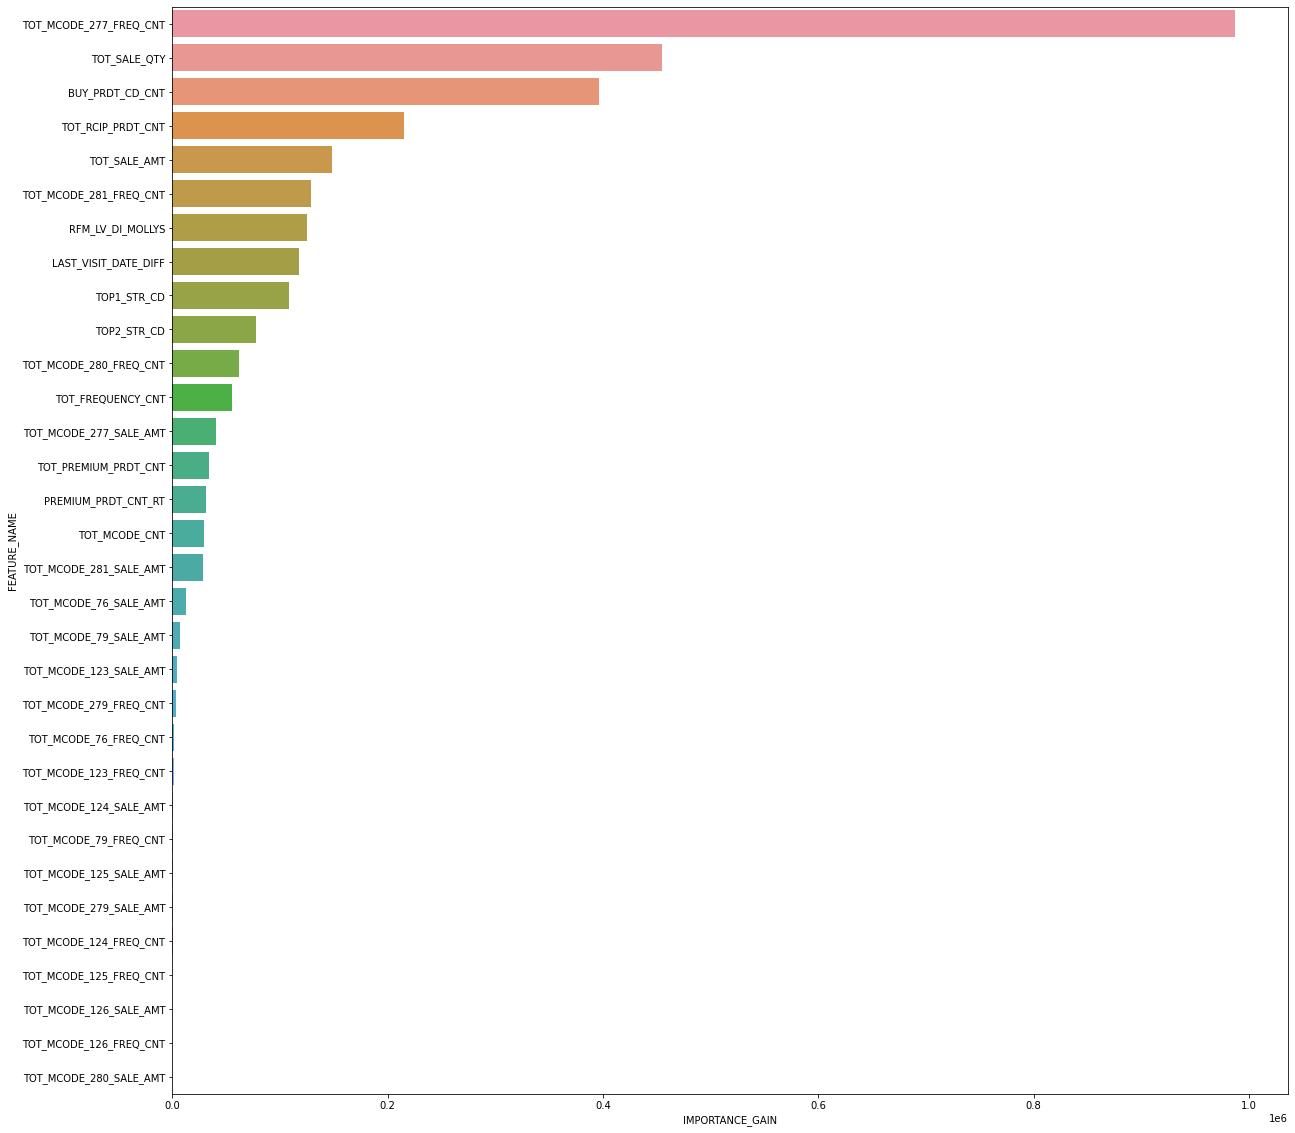

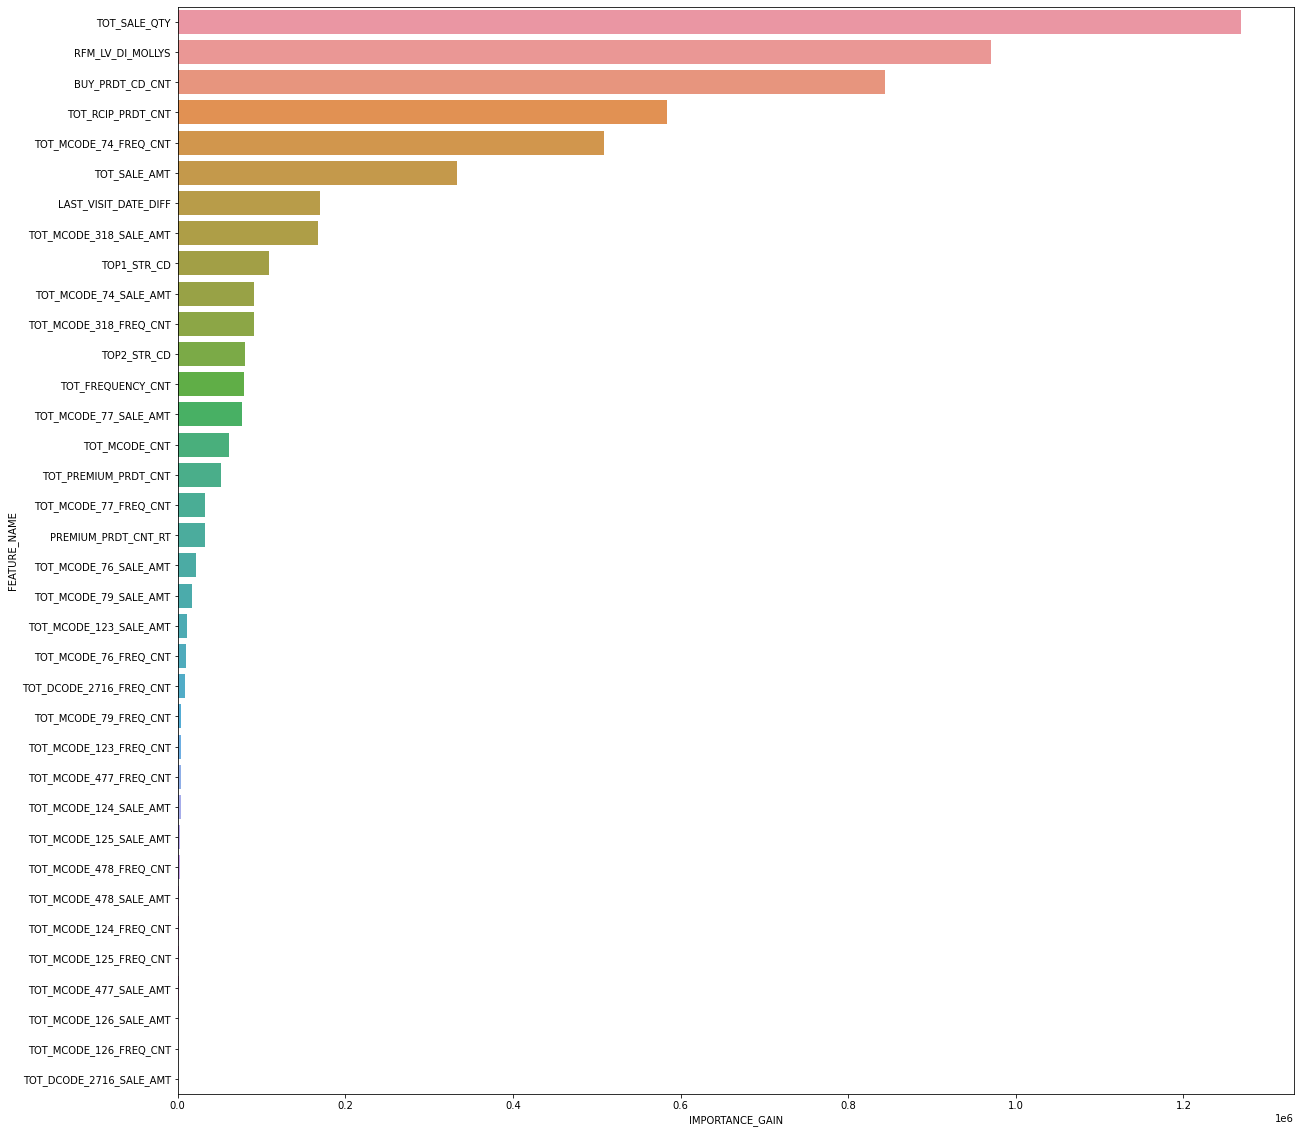

In [34]:
cat_fi = clf_feature_importance('CAT_POTENTIAL_FOOD_MODEL32_FEATURE.pkl')
dog_fi = clf_feature_importance('DOG_POTENTIAL_FOOD_MODEL36_FEATURE.pkl')

## FI- Premutaion Importance

PI
Counter({0: 579860, 1: 104725})
■ [PID]          : 199659 
■ [Jupyter path] : /home/cdsadmin/python_src/EY/YSR
■ [Kernel ID]    : a76ea463-4c65-4659-8a9b-68022eae5998


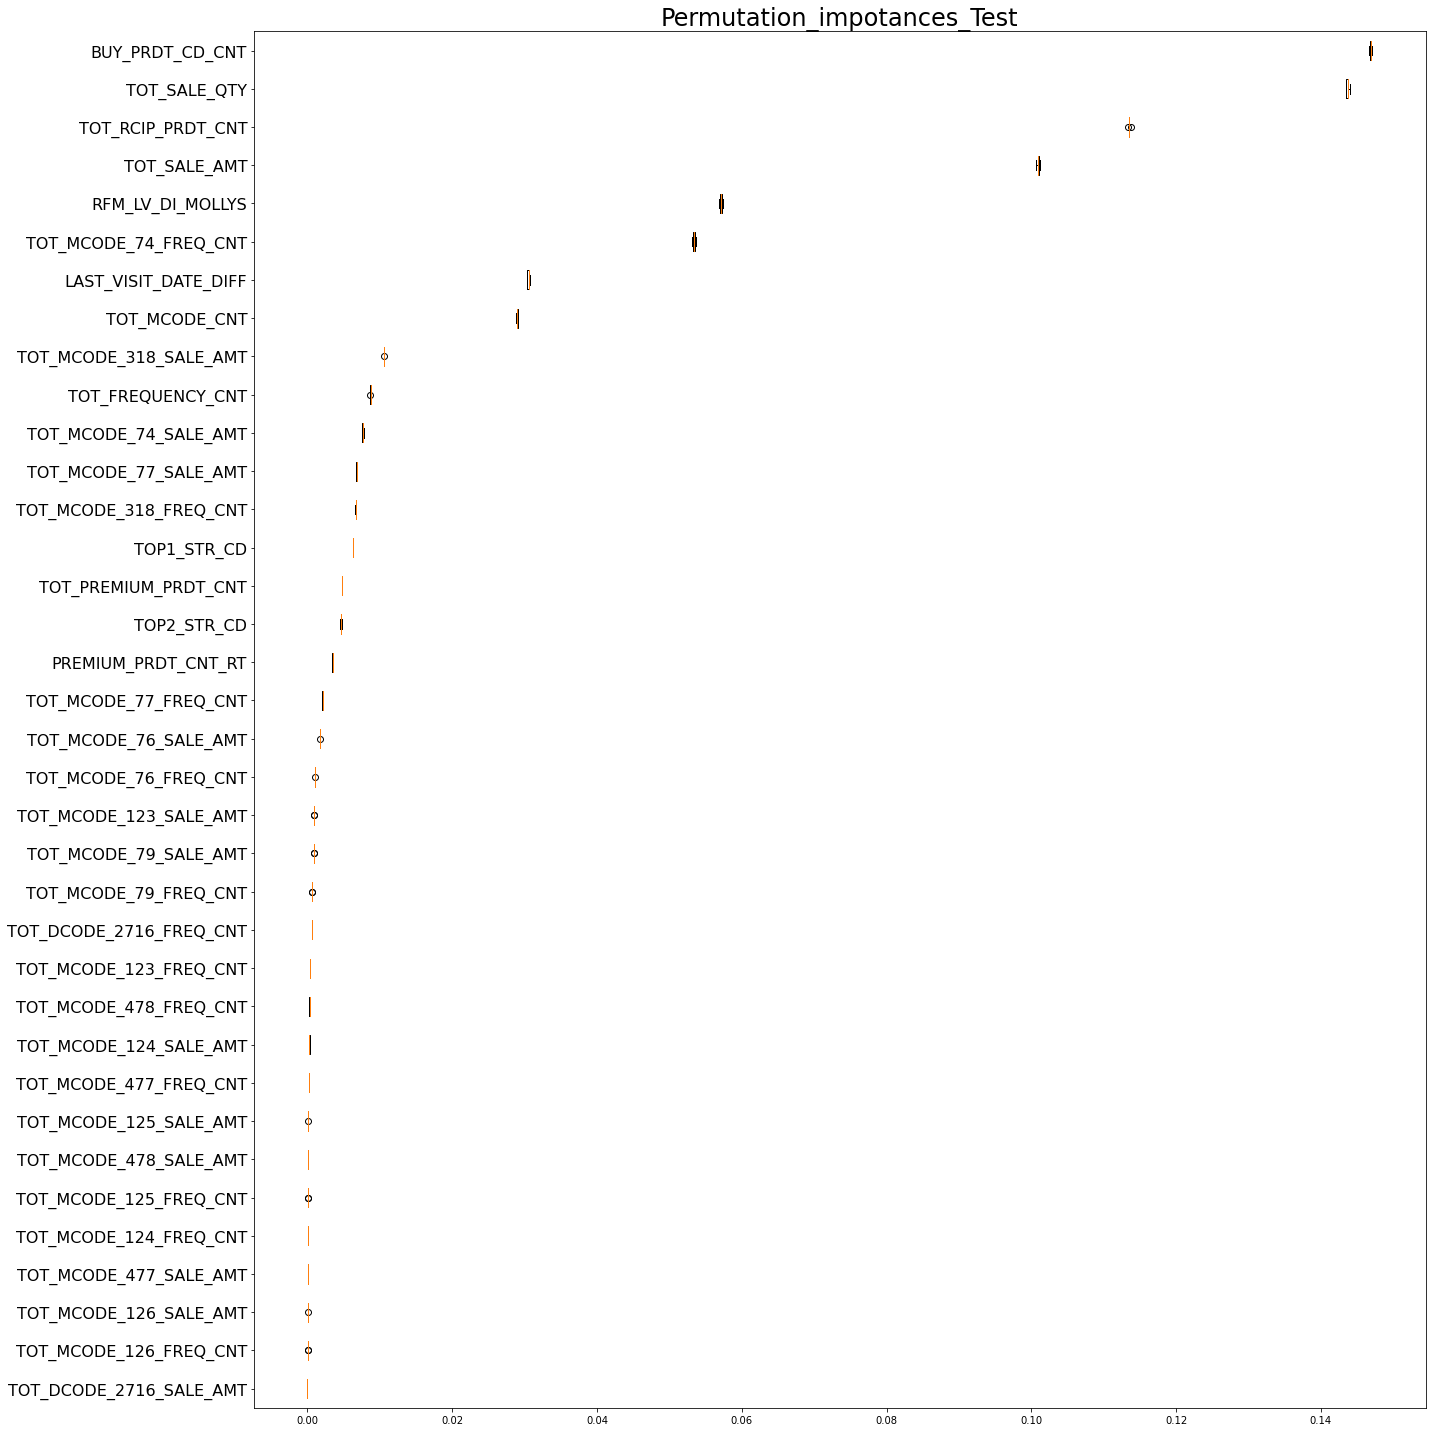

소요시간 : 300.0 초   ( 5 분 )

PI
Counter({0: 643147, 1: 41438})
■ [PID]          : 199659 
■ [Jupyter path] : /home/cdsadmin/python_src/EY/YSR
■ [Kernel ID]    : a76ea463-4c65-4659-8a9b-68022eae5998


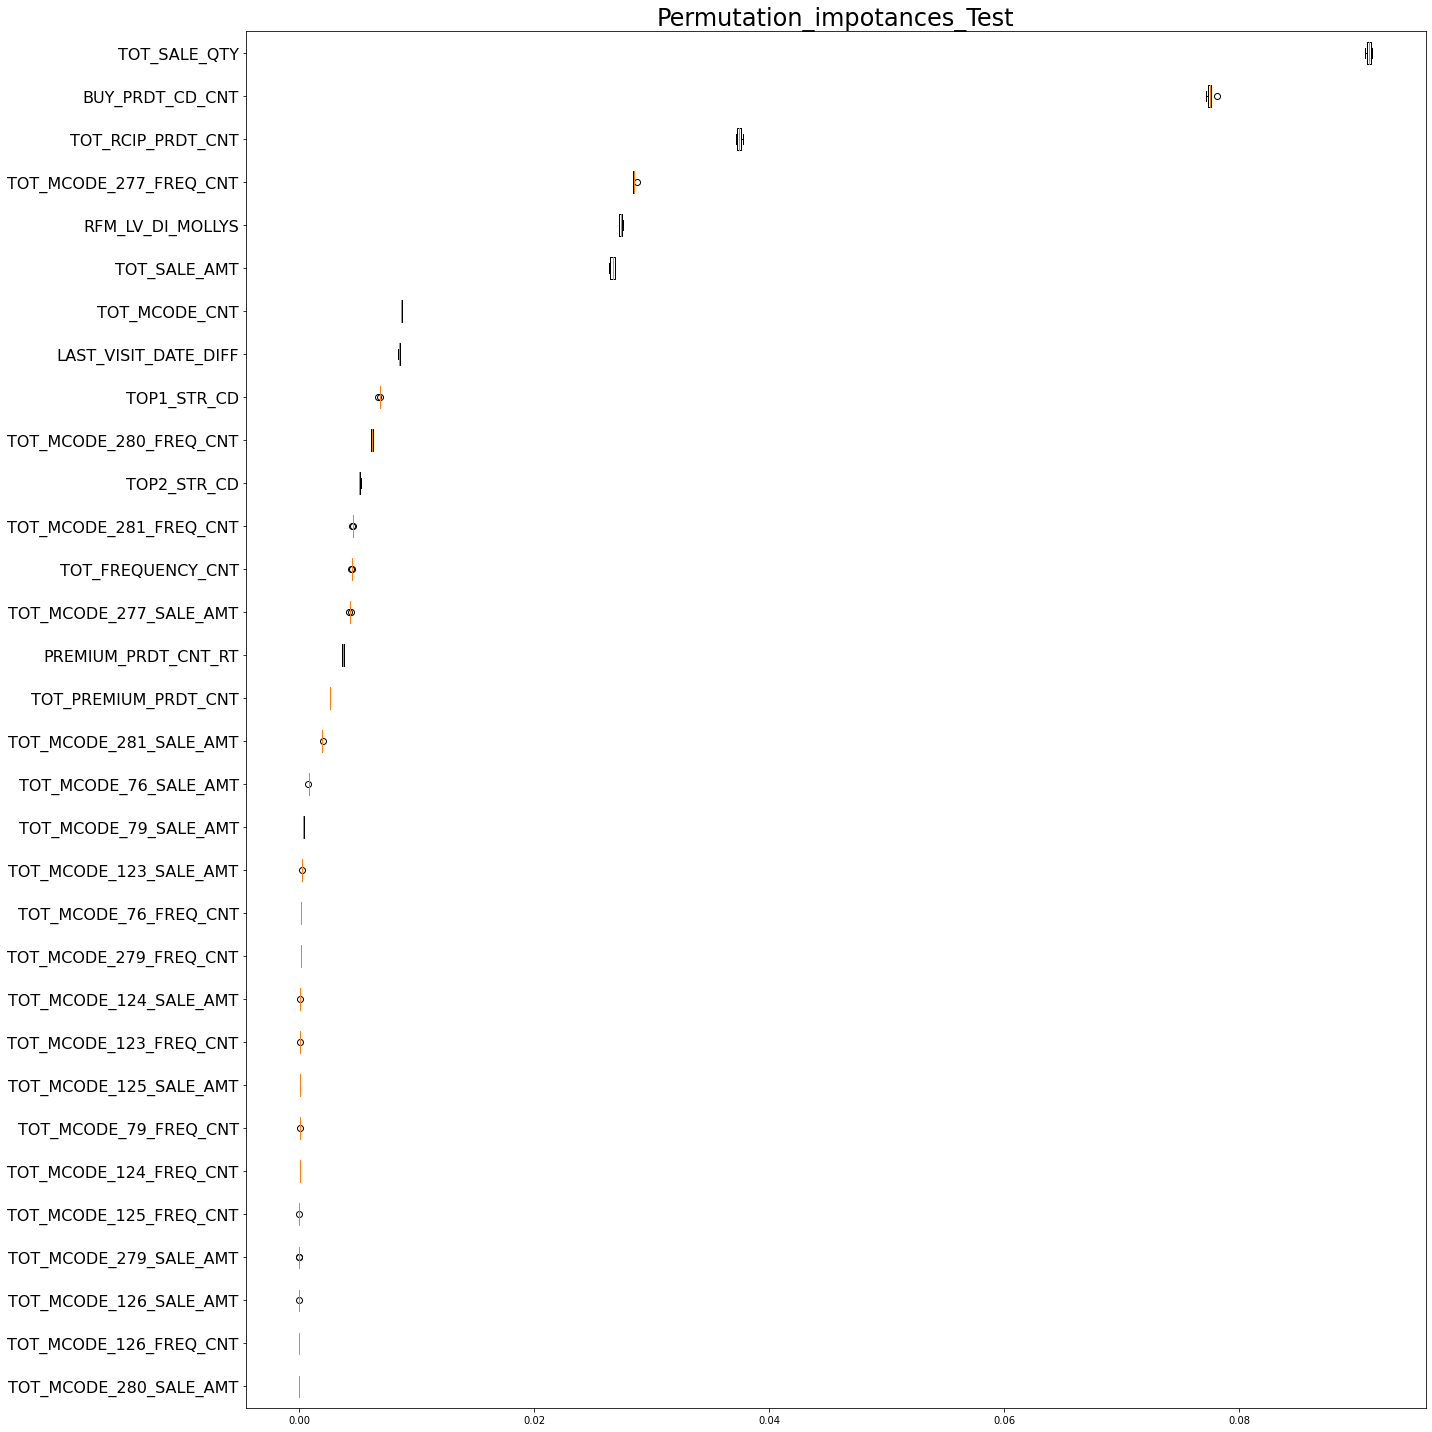

소요시간 : 260.0 초   ( 4 분 )



In [35]:
dog_pi = PermutaionImportance(dog_model,D_X_train,D_Y_train)
cat_pi = PermutaionImportance(cat_model,C_X_train,C_Y_train)

In [54]:
def make_importance_df(fi_df,pi_df):
    pi_df.columns     = ['FEATURE_NAME','IMPORTANCE_PI']
    fi_all            = pd.merge(fi_df,pi_df,on=['FEATURE_NAME'])
    fi_all['PI_RANK'] = fi_all['IMPORTANCE_PI'].rank(ascending=False)
    fi_all            = fi_all.reindex(columns=['FEATURE_NAME','IMPORTANCE_SPLIT','IMPORTANCE_GAIN','IMPORTANCE_PI','SPLIT_RANK','GAIN_RANK','PI_RANK'])    
    fi_all.sort_values(by=['PI_RANK'])
    return fi_all

dog_pi = make_importance_df(dog_fi,dog_pi)
cat_pi = make_importance_df(cat_fi,cat_pi)

,FEATURE_NAME,IMPORTANCE_SPLIT,IMPORTANCE_GAIN,IMPORTANCE_PI,SPLIT_RANK,GAIN_RANK,PI_RANK
6,TOT_SALE_QTY,21955,454919.418364,8.928416e-02,6.0,2.0,1.0
8,BUY_PRDT_CD_CNT,16935,396166.776226,8.844073e-02,9.0,3.0,2.0
2,TOT_RCIP_PRDT_CNT,19752,214875.738067,4.129684e-02,7.0,4.0,3.0
5,TOT_SALE_AMT,55347,147948.981633,2.932054e-02,1.0,5.0,4.0
9,RFM_LV_DI_MOLLYS,45432,125581.174767,2.890218e-02,4.0,7.0,5.0
24,TOT_MCODE_277_FREQ_CNT,5296,987175.796023,2.741603e-02,15.0,1.0,6.0
0,LAST_VISIT_DATE_DIFF,54774,117838.351298,1.189509e-02,2.0,8.0,7.0
10,TOP1_STR_CD,52978,108534.875400,1.033268e-02,3.0,9.0,8.0
7,TOT_MCODE_CNT,5865,29640.878764,8.988803e-03,14.0,16.0,9.0
11,TOP2_STR_CD,36922,77450.357639,7.485703e-03,5.0,10.0,10.0


## Reference

### Visualization

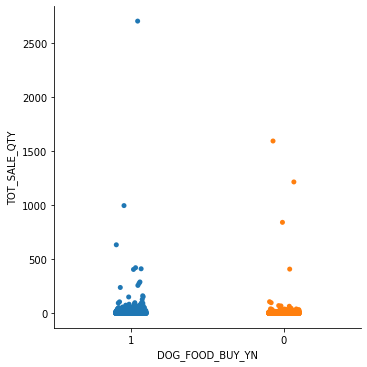

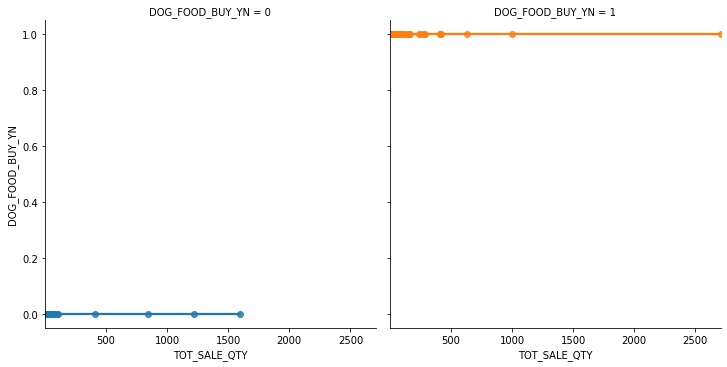

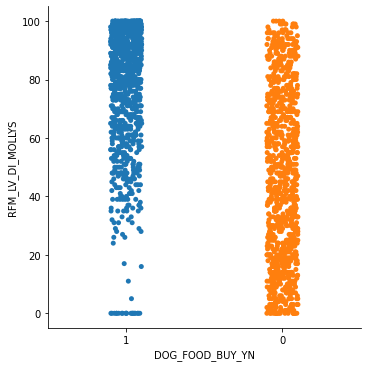

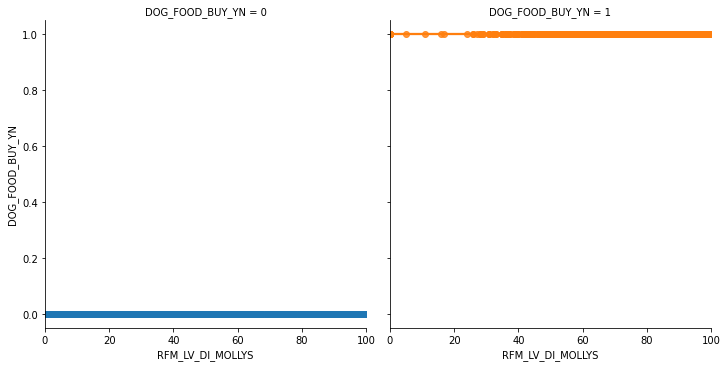

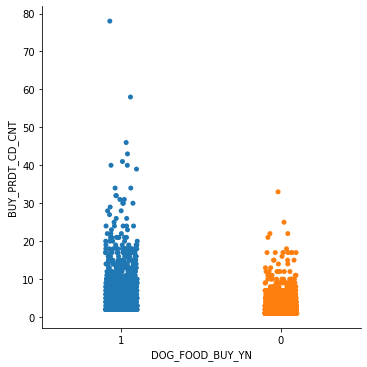

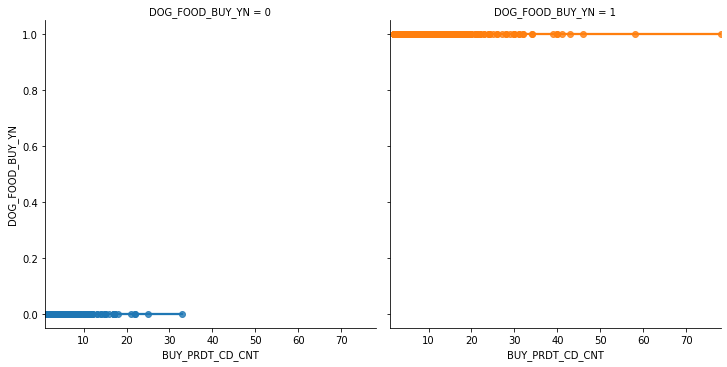

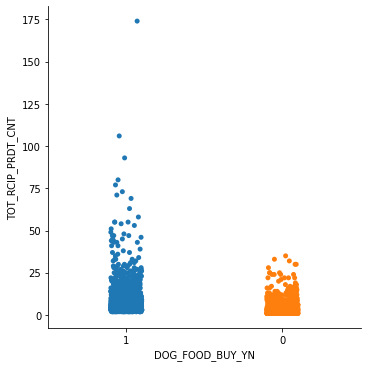

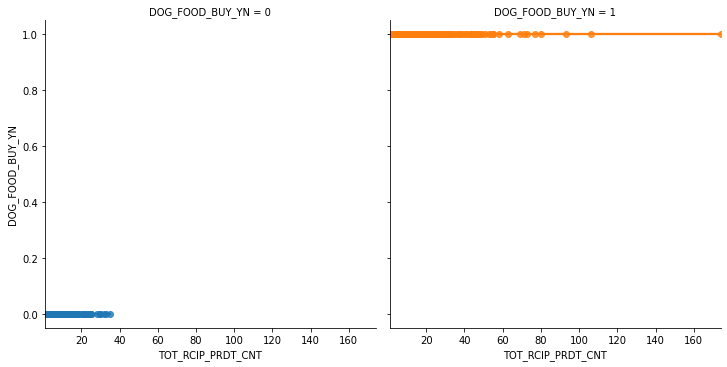

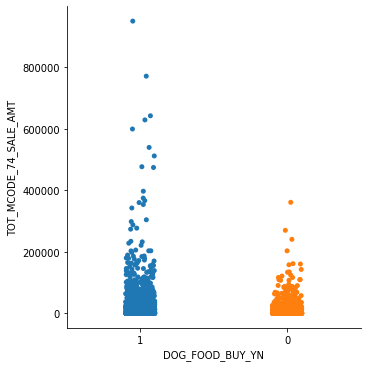

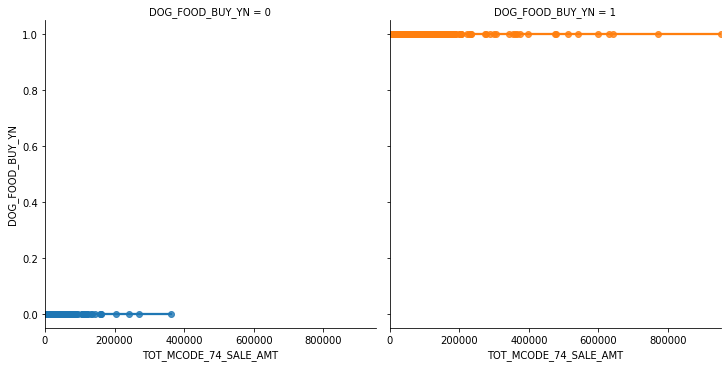

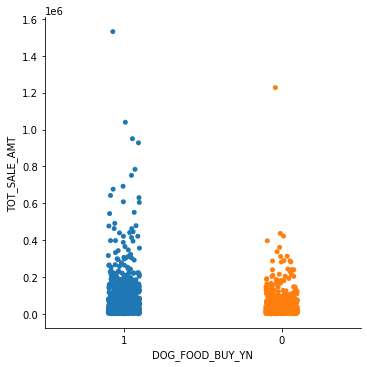

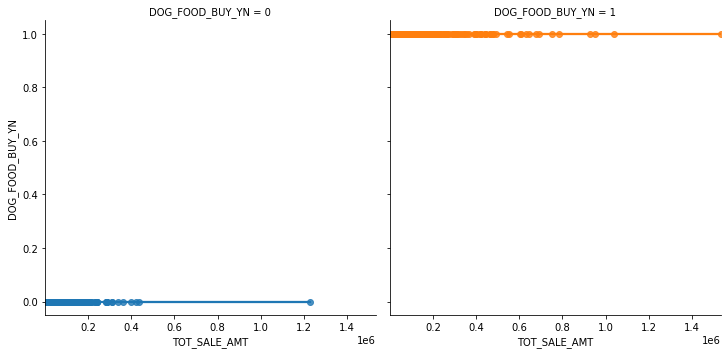

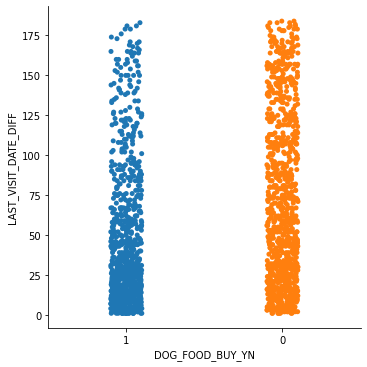

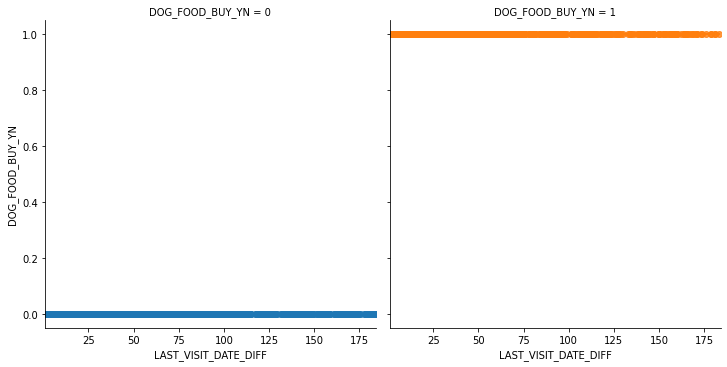

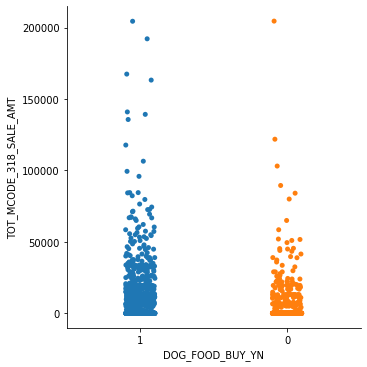

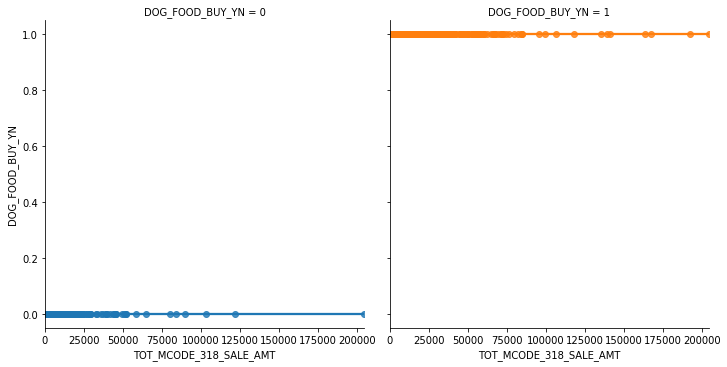

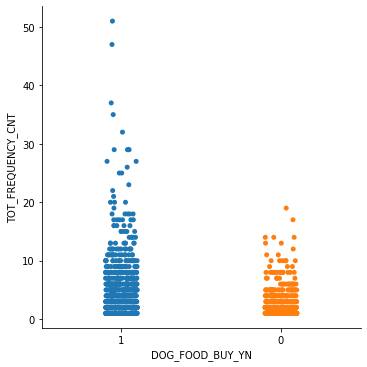

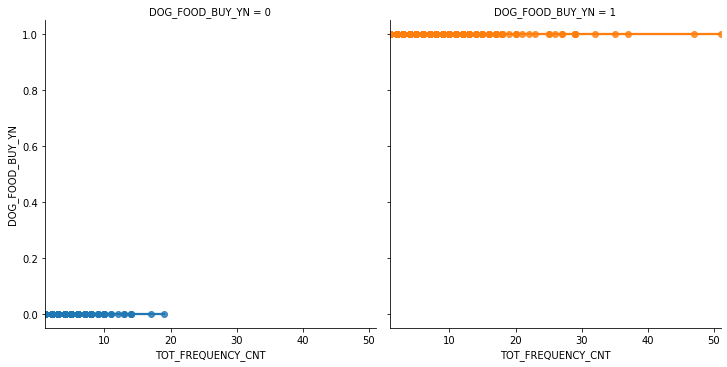

In [192]:
def make_sample_data(df,Y_label):
    target_sample = df[df[Y_label] == 1].sample(1000)
    non_target_sample = df[df[Y_label] == 0].sample(1000)
    sample_df = pd.concat([target_sample,non_target_sample])
    return sample_df 

def EDA_distributions(df,col_list,Y_label):   
    for column in col_list:
        cc = [column]
#         display(df_1.groupby(['CLASS_CAT'])[cc].describe())
        sns.catplot(x=Y_label, y=cc[0], order=[1,0], data=df)
        sns.lmplot(data=df,
                   x= column,
                   y=Y_label,
                   hue=Y_label,
                   col=Y_label)
        
cols_list = ['TOT_SALE_QTY'
            ,'RFM_LV_DI_MOLLYS'
            ,'BUY_PRDT_CD_CNT'
            ,'TOT_RCIP_PRDT_CNT'
            ,'TOT_MCODE_74_SALE_AMT'
            ,'TOT_SALE_AMT'
            ,'LAST_VISIT_DATE_DIFF'
            ,'TOT_MCODE_318_SALE_AMT'
            ,'TOT_FREQUENCY_CNT']

sample_data = make_sample_data(df,DOG_Y_label)
EDA_distributions(sample_data,cols_list,DOG_Y_label)

### correlation_matrix

In [36]:
def correlation_matrix(df,Y_label):
    ## 상관관계가 0.3 이상인 강한 상관관계를 보이는 변수만 선택
    corr_matrix = df.corr()
    top_corr_feature = corr_matrix.index[abs(corr_matrix[Y_label]) >= 0.3].to_list()
    except_cols = set(df.columns.tolist()) - set(top_corr_feature)
    
    rank_corr_feature = abs(corr_matrix[abs(corr_matrix[Y_label]) >= 0.3])
    rank_corr_feature = rank_corr_feature.sort_values(by=[Y_label],ascending=False)
    
    print('(Y)와 상관계수가 0.3 이하인 약한 상관관계를 보이는 변수 : %s'%except_cols )
    plt.figure(figsize=(13,10))
    sns.heatmap(corr_matrix, annot = True)
    plt.show()
    return corr_matrix

### Logistics Regression 

In [123]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression(random_state=0).fit(D_X_train, D_Y_train)
y_pred      = logit_model.predict(D_X_test)
y_pred_prob = logit_model.predict_proba(D_X_test)

/emartcds/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [124]:
model_score(y_test = D_Y_test,y_pred = y_pred ,y_pred_prob = y_pred_prob)

==============================   ACCURACY  =================================
ACCURACY : 0.97%
==============================   COUNT DATA   ==============================
test_Target_Count : 3866
pred_Target_Count : 5393
===========================   Confusion Matrix   ===========================
[[173668   3767]
 [  2240   1626]]
TN : 173668
TP : 1626
FN : 2240
FP : 3767
=========================   Precision / Recall   ===========================
precision_rate : 0.30 (TP+/TP+FP)
recall_rate : 0.42 (TP+/TP+FN)
=============================   F1 SCORE   =================================
f1_score :  0.35 (2*((precision * recall)/(precision+recall)))


              precision    recall  f1-score   support

           0      0.987     0.979     0.983    177435
           1      0.302     0.421     0.351      3866

    accuracy                          0.967    181301
   macro avg      0.644     0.700     0.667    181301
weighted avg      0.973     0.967     0.970    181301



In [136]:
pd.DataFrame({'FEATURE_NAME':D_X_train.columns.tolist()
             ,'COEF':logit_model.coef_[0].tolist()})

,FEATURE_NAME,COEF
0,LAST_VISIT_DATE_DIFF,-0.219077
1,TOT_FREQUENCY_CNT,-0.015630
2,TOT_RCIP_PRDT_CNT,-0.050435
3,TOT_PREMIUM_PRDT_CNT,-0.037817
4,PREMIUM_PRDT_CNT_RT,-0.006917
5,TOT_SALE_AMT,0.000003
6,TOT_SALE_QTY,-0.012264
7,TOT_MCODE_CNT,-0.012688
8,BUY_PRDT_CD_CNT,0.053943
9,RFM_LV_DI_MOLLYS,0.073166
